In [1]:
import os
import math
import torch
import torch.nn as nn
import traceback

import time
import numpy as np

import argparse

from utils.generic_utils import load_config, load_config_from_str
from utils.generic_utils import set_init_dict

#from utils.tensorboard import TensorboardWriter

from utils.dataset import test_dataloader

#from utils.generic_utils import validation, PowerLaw_Compressed_Loss, SiSNR_With_Pit

from models.voicefilter.model import VoiceFilter
from models.voicesplit.model import VoiceSplit
from models.voicedenoising.model import VoiceDenoising
from utils.audio_processor import WrapperAudioProcessor as AudioProcessor 

In [2]:
c = load_config('/home/fred/Documentos/SpeechDenoising/config.json')


In [3]:

ap = AudioProcessor(c.audio)


In [4]:
cuda = torch.cuda.is_available()
print(cuda)

True


In [5]:
audio_config = c.audio[c.audio['backend']]

In [6]:
c.dataset['test_dir'] = '/home/fred/Documentos/SpeechDenoising/data_test/'

test_dataloader = test_dataloader(c, ap)

In [7]:
model = VoiceDenoising(c)

In [8]:
checkpoint = torch.load('/home/fred/Documentos/SpeechDenoising/checkpoints-15-09-20/voicedenoising/checkpoint_85000.pt', map_location='cpu')
model.load_state_dict(checkpoint['model'])
if cuda:
    model = model.cuda()

In [9]:
model.eval()


VoiceDenoising(
  (conv): Sequential(
    (0): ZeroPad2d(padding=(3, 3, 0, 0), value=0.0)
    (1): Conv2d(1, 64, kernel_size=(1, 7), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ZeroPad2d(padding=(0, 0, 3, 3), value=0.0)
    (5): Conv2d(64, 64, kernel_size=(7, 1), stride=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): ZeroPad2d(padding=(2, 2, 2, 2), value=0.0)
    (9): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ZeroPad2d(padding=(2, 2, 4, 4), value=0.0)
    (13): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), dilation=(2, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): ZeroPad2d(padding=(2, 2, 8, 8), value=0.0)
    (17): Conv2d(64, 64

In [14]:
target_spec, mixed_spec, target_wav, mixed_wav, mixed_phase, seq_len = batch = next(iter(test_dataloader))

In [11]:
#mixed_spec = mixed_spec.unsqueeze(0)

In [15]:
if cuda:
    mixed_spec = mixed_spec.cuda()


In [17]:
est_mask = model(mixed_spec)
   

In [18]:
est_mag = est_mask * mixed_spec
mixed_spec = mixed_spec[0].cpu().detach().numpy()
 

In [19]:
est_mag = est_mag[0].cpu().detach().numpy()
mixed_phase = mixed_phase[0].cpu().detach().numpy()


In [22]:
est_wav = ap.inv_spectrogram(est_mag, phase=mixed_phase)
#est_mask = est_mask[0].cpu().detach().numpy()


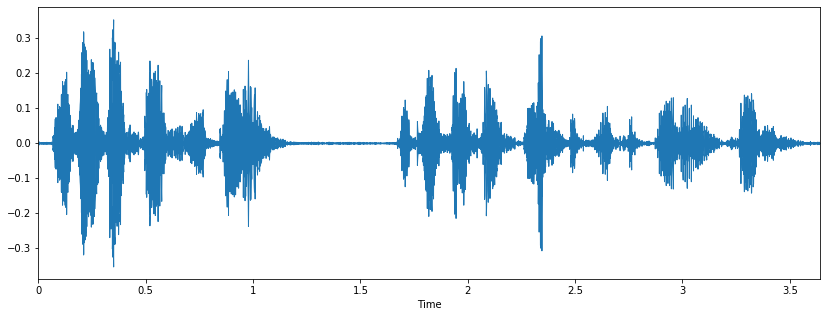

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(target_wav[0].cpu().detach().numpy(), sr=16000)


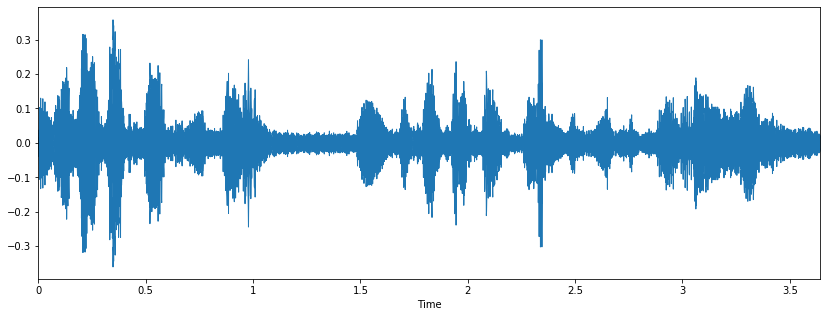

In [39]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(mixed_wav[0].cpu().detach().numpy(), sr=16000)


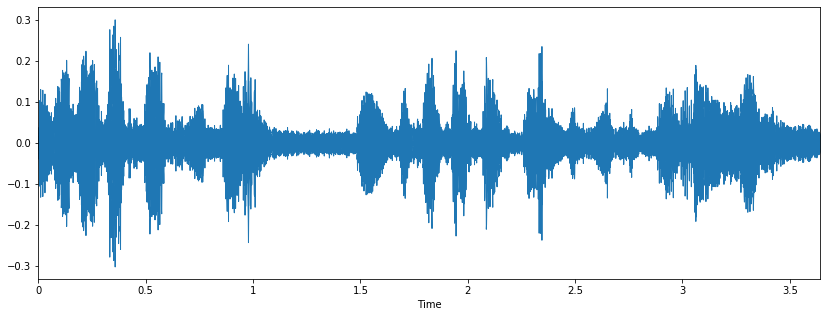

In [40]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(est_wav, sr=16000)

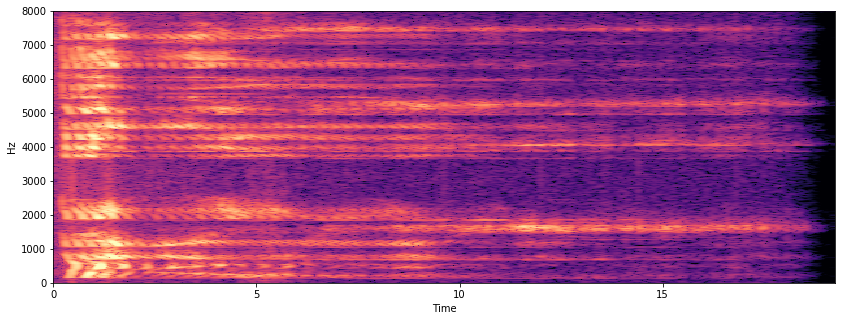

In [44]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(target_spec[0].cpu().detach().numpy(), sr=16000, x_axis='time', y_axis='hz')



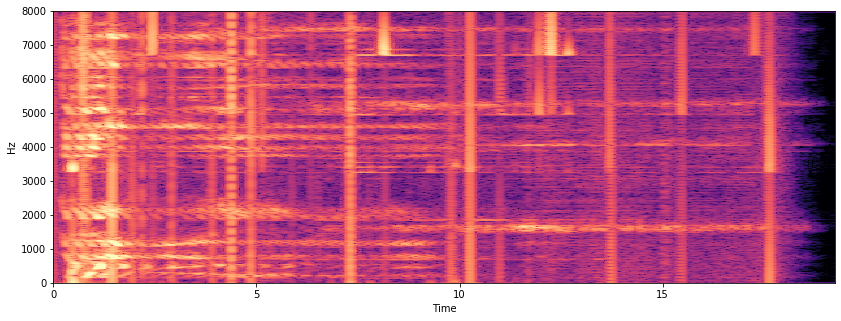

In [48]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mixed_spec, sr=16000, x_axis='time', y_axis='hz')


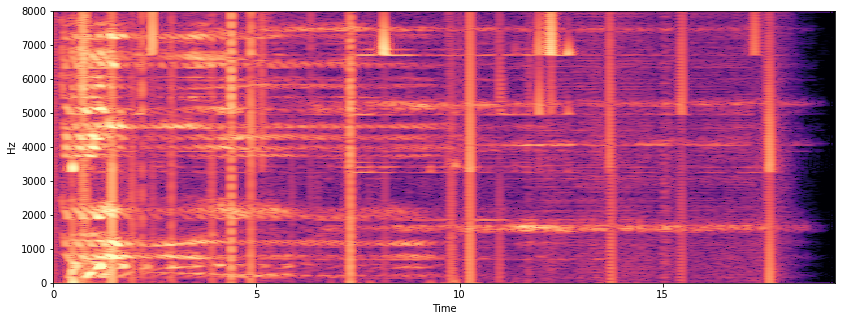

In [49]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(est_mag, sr=16000, x_axis='time', y_axis='hz')


In [27]:
import IPython
IPython.display.Audio(est_wav, rate=16000)

In [28]:
IPython.display.Audio(mixed_wav, rate=16000)

In [41]:
IPython.display.Audio(target_wav, rate=16000)